# Trial clustering

In [1]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy import stats

# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.cluster import KMeans

from one.api import ONE
import matplotlib.pyplot as plt

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from plotting_functions import bins_per_trial_phase, broader_label
from one_functions_generic import prepro
from design_functions import wheel_velocity
from data_processing import time_intervals, process_quiescence
from wheel_functions import find_periods_below_threshold, create_movement_array, stack_trial_events, wheel_trial_epoch
one = ONE(base_url='https://alyx.internationalbrainlab.org')


## Parameters

In [2]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
# data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'

data_path = data_path_v2

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

## Load data

List design matrices' eids

In [3]:
# Save data of all sessions for latter
idxs = []
mouse_names = []
for m, mat in enumerate(design_matrices):
    
    mouse_name = design_matrices[m][51:-4]
    eid = design_matrices[m][14:50]
    idx = str(eid + '_' + mouse_name)
    if m == 0:
        idxs = idx
        mouse_names = mouse_name
    else:
        idxs = np.hstack((idxs, idx))
        mouse_names = np.hstack((mouse_names, mouse_name))

In [4]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for m, mouse_name in enumerate(mouse_names):
    # Save results per mouse
    matrix_all[mouse_name] = {}
    session_all[mouse_name] = {}
    matrix_all_unnorm[mouse_name] = {}

for m, mat in enumerate(idxs):
    if len(mat) > 35: 
            
        # Trials data
        session = mat[0:36]
        mouse_name = mat[37:]

        session_trials = one.load_object(session, obj='trials', namespace='ibl')
        session_trials = session_trials.to_df()
        session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
        session_start = list(session_trials['stimOn_times'])[0]

        # Get time of last unbiased trial
        unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
        time_trial_90 = list(unbiased['stimOff_times'])[-1]
        
        filename = str('design_matrix_' + mat + '_'  + str(bin_size))  # + mouse_name + '_'
                
        big_design_matrix = pickle.load(open(filename, "rb"))
        design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
        design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
        design_matrix = design_matrix.dropna()
    
        # Keep only first 90 trials
        # design_matrix = design_matrix.loc[(design_matrix['Bin'] < time_trial_90 * 10) & (design_matrix['Bin'] > session_start * 10)]
        # unbiased_trials = session_trials.loc[session_trials['stimOff_times'] < time_trial_90]

        design_matrix = design_matrix.loc[(design_matrix['Bin'] < session_end * 10) & (design_matrix['Bin'] > session_start * 10)]
        unbiased_trials = session_trials.loc[session_trials['stimOff_times'] < session_end]
        
        training_set = np.array(design_matrix[var_names]).copy() 
        
        if len(training_set) > 0:
            # Standardization using StandardScaler
            scaler = StandardScaler()
            standardized = scaler.fit_transform(training_set)
            # Normalize between 0 and 1
            normalizer = Normalizer().fit(standardized)
            normalized = normalizer.transform(standardized)
            
            matrix_all[mouse_name][session] = normalized
            session_all[mouse_name][session] = unbiased_trials    
            matrix_all_unnorm[mouse_name][session] = design_matrix
            
        else:
            print(session)
    else:
        print(mat)

local md5 mismatch on dataset: churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.60k/4.60k [00:00<00:00, 13.8kB/s]
local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-10/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS023/2019-12-10/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.26k/5.26k [00:00<00:00, 15.8kB/s]


_
poch_DY_013.png_
portances.svg_


local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-06/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS023/2019-12-06/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.35k/5.35k [00:00<00:00, 15.9kB/s]
local md5 mismatch on dataset: cortexlab/Subjects/KS014/2019-12-03/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS014/2019-12-03/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.38k/4.38k [00:00<00:00, 13.1kB/s]


lls_
_
poch_CSHL060.png_
_matrix_


local md5 mismatch on dataset: cortexlab/Subjects/KS014/2019-12-07/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS014/2019-12-07/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.38k/5.38k [00:00<00:00, 14.9kB/s]


1b61b7f2-a599-4e40-abd6-3e758d2c9e25
_


## Concatenate sessions of the same animal

In [5]:
collapsed_matrices = defaultdict(list)
collapsed_unnorm = defaultdict(list)
collapsed_trials = defaultdict(list)

# Collapse multiple sessions per mouse
for mouse in np.unique(mouse_names):
    if len(np.where(mouse_names==mouse)[0]) > 1 and len(mouse) > 0:
        mouse_sessions = list(matrix_all[mouse].keys())
        for s, session in enumerate(mouse_sessions):
            collapsed_matrices[mouse] = np.vstack(matrix_all[mouse][session])
            collapsed_unnorm[mouse] = np.vstack(matrix_all_unnorm[mouse][session])
            collapsed_trials[mouse] = pd.concat(session_all[mouse], ignore_index=True)

## Loop through animals

In [42]:
broader = True
var = 'broader_label'

all_animals_df = pd.DataFrame(columns=np.concatenate(([var], var_names)))

for m, mat in enumerate(idxs[0:1]):
    if len(mat) > 35: 
        
        session_df = pd.DataFrame(columns=np.concatenate(([var], var_names)))
        # Trials data
        session = mat[0:36]
        # Mouse name
        mouse_name = mat[37:]
        
        print('Fitting mouse ' + mouse_name)

        # Get mouse data
        session_trials = session_all[mouse_name][session]
        design_matrix = matrix_all[mouse_name][session]
        unnorm_mat = matrix_all_unnorm[mouse_name][session]
        
        if len(np.shape(design_matrix)) > 2:
            design_matrix = design_matrix[0]
            session_trials = session_trials[0]
            unnorm_mat = matrix_all_unnorm[mouse_name][0]

        " Prepare design matrix "
        design_matrix_heading = pd.DataFrame(columns=var_names)
        design_matrix_heading[var_names] = design_matrix
        bins = unnorm_mat['Bin']
        design_matrix_heading['Bin'] = bins
        
        # Absolute wheel velocity
        design_matrix_heading['avg_wheel_vel'] = np.abs(design_matrix_heading['avg_wheel_vel'])
        unnorm_mat['avg_wheel_vel'] = np.abs(unnorm_mat['avg_wheel_vel'])

        # # Get trial phase
        # bins_df = bins_per_trial_phase(design_matrix_heading, session_trials)
        # bins_df = bins_df.rename(columns={0: 'Bin'})
        # new_df = design_matrix_heading.merge(bins_df, on='Bin')

        # Wheel data
        wheel = wheel_trial_epoch(one, session_trials, session, bin_size)
        wheel_df = process_quiescence(wheel)
        wheel_df = wheel_df.rename(columns={"trial": "Trial"})
        wheel_df = wheel_df.groupby(['Trial', 'feedback', 'next_feedback', 'response', 'reaction'])['quiesc_length', 'time_to_quiesc', 
                                                                            'pre_quiesc_move_duration', 'pre_quiesc_move_count'].mean().reset_index()

        # Get trial phase
        bins_df = bins_per_trial_phase(unnorm_mat, session_trials)
        bins_df = bins_df.rename(columns={0: 'Bin'})
        new_df = unnorm_mat.merge(bins_df, on='Bin')

        # Get broader labels
        new_df = broader_label(new_df)
        
        # Get timings
        # new_df = new_df.merge(session_trials[[]])
        
        # Average per trial epoch and append side by side
        # appended_df = pd.DataFrame()
        # for i, v in enumerate(new_df[var].unique()):
        #     session_df = new_df.groupby(['Trial', 'choice', var])[var_names].mean().reset_index()
        #     if i == 0:
        #         appended_df = session_df.loc[session_df[var]=='Choice'].reset_index()
        #     else:
        #         appended_df = pd.concat([appended_df, session_df.loc[session_df[var]=='Choice'].reset_index()[var_names]], axis=1)
        
        appended_df = new_df.groupby(['Trial', 'choice'])[var_names].mean().reset_index()

        # Merge the two dataframes
        final_df = appended_df.merge(wheel_df, on='Trial')
        # final_df = final_df.drop(columns=['index', var])
        
        # Save results
        if m == 0:
            all_animals_df = final_df.copy()
        else:
            all_animals_df = all_animals_df.append(final_df)
        

Fitting mouse SWC_052


/home/ines/repositories/representation_learning_variability/Functions/data_processing.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['movement_duration'][1:] = np.diff(new_df['movement_onset'])
/tmp/ipykernel_24151/3514577929.py:46: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  wheel_df = wheel_df.groupby(['Trial', 'feedback', 'next_feedback', 'response', 'reaction'])['quiesc_length', 'time_to_quiesc',
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representati

## PCA

In [43]:
"""
PRINCIPLE COMPONENT ANALYSES
"""
use_data = np.array(final_df.drop(columns='Trial').dropna())  # Could it be a problem that I have only 10 x feature for the samples?
use_data = final_df.drop(columns=['Trial', 'choice', 'feedback', 
                                           'next_feedback', 'pre_quiesc_move_count'])  # Could it be a problem that I have only 10 x feature for the samples?

scaler = StandardScaler()
standardized = scaler.fit_transform(np.array(use_data.dropna()))
# Normalize between 0 and 1
normalizer = Normalizer().fit(standardized)
normalized = normalizer.transform(standardized)


X = normalized # (n_samples, n_features)

# Mean centered and equal variance (redundant code)
#scaler = StandardScaler()
#scaler.fit(X)

pca = PCA() # svd_solver='full'
#pca.fit(scaler.transform(X))
X_reduced = pca.fit_transform(scaler.transform(X))


In [44]:
# Plot projections of datapoints into first 3 principal components
augmented_data = pd.DataFrame(columns=['Trial'], index=range(len(X_reduced)))
augmented_data['Trial'] = range(len(X_reduced))  # this keeps trials as consecutive, while in fact some trials are missing
augmented_data['feedback'] = final_df['feedback']  
augmented_data['next_feedback'] = final_df['next_feedback']  
augmented_data['choice'] = final_df['choice'] 

augmented_data['pc1'] = X_reduced[:, 0].transpose()
augmented_data['pc2'] = X_reduced[:, 1].transpose()
augmented_data['pc3'] = X_reduced[:, 2].transpose()
augmented_data['pc4'] = X_reduced[:, 3].transpose()
augmented_data['pc5'] = X_reduced[:, 4].transpose()
augmented_data['pc6'] = X_reduced[:, 5].transpose()
augmented_data['pc7'] = X_reduced[:, 6].transpose()
augmented_data['pc8'] = X_reduced[:, 7].transpose()
augmented_data['pc9'] = X_reduced[:, 8].transpose()
augmented_data['pc10'] = X_reduced[:, 9].transpose()

Text(0, 0.5, '% Variance explained')

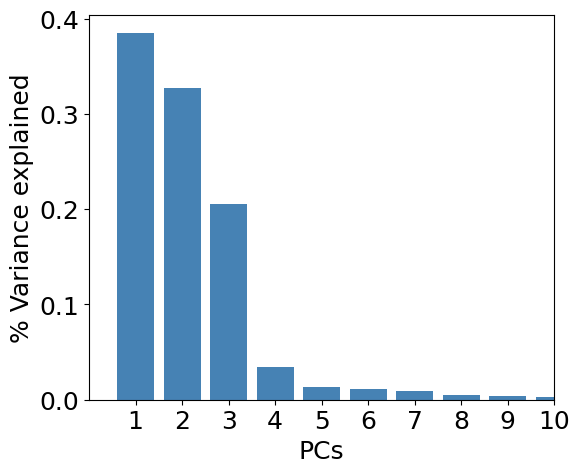

In [45]:
# Plot variance explained per principle component
fig, ax = plt.subplots(figsize=[6,5])
plt.rc('font', size=18)
keep_pc = np.shape(X)[1]
plt.bar(np.arange(1, keep_pc+1, 1), pca.explained_variance_ratio_[0:keep_pc], color='steelblue')
plt.xticks(np.arange(1, keep_pc, 1))
plt.xlim([0, 10])
plt.xlabel('PCs')
plt.ylabel('% Variance explained')

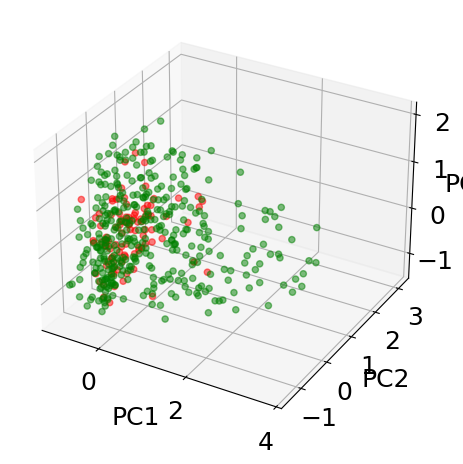

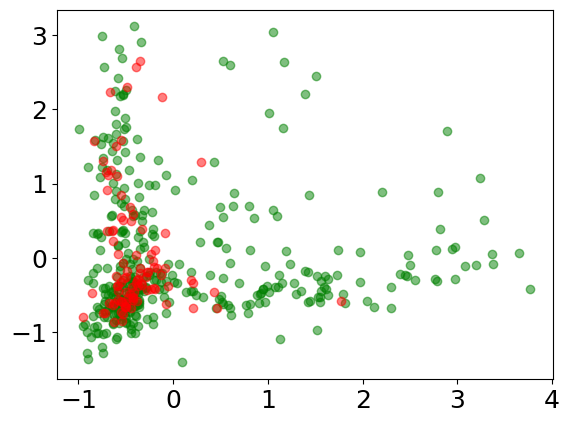

In [50]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

var_interest = 'feedback'
correct_data = augmented_data.loc[augmented_data[var_interest]==1]
ax.scatter(correct_data['pc1'], correct_data['pc2'], correct_data['pc3'], alpha=0.5, color='green')
incorrect_data = augmented_data.loc[augmented_data[var_interest]==-1]
ax.scatter(incorrect_data['pc1'], incorrect_data['pc2'], incorrect_data['pc3'], alpha=0.5, color='red')

# Set labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.tight_layout()
plt.show()

# plt.scatter(correct_data['pc1'], correct_data['pc2'], alpha=0.5, color='green')
# plt.scatter(incorrect_data['pc1'], incorrect_data['pc2'], alpha=0.5, color='red')




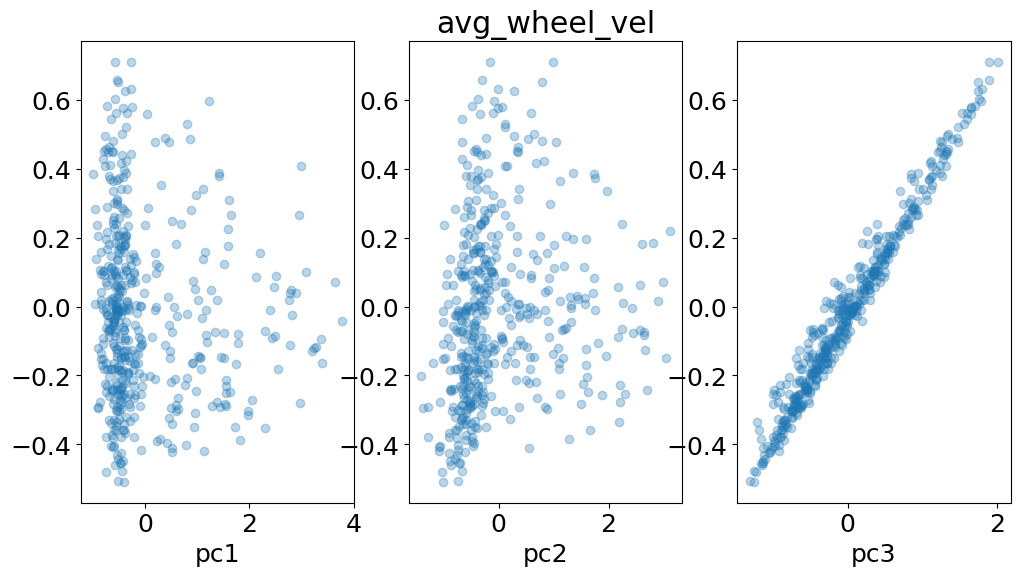

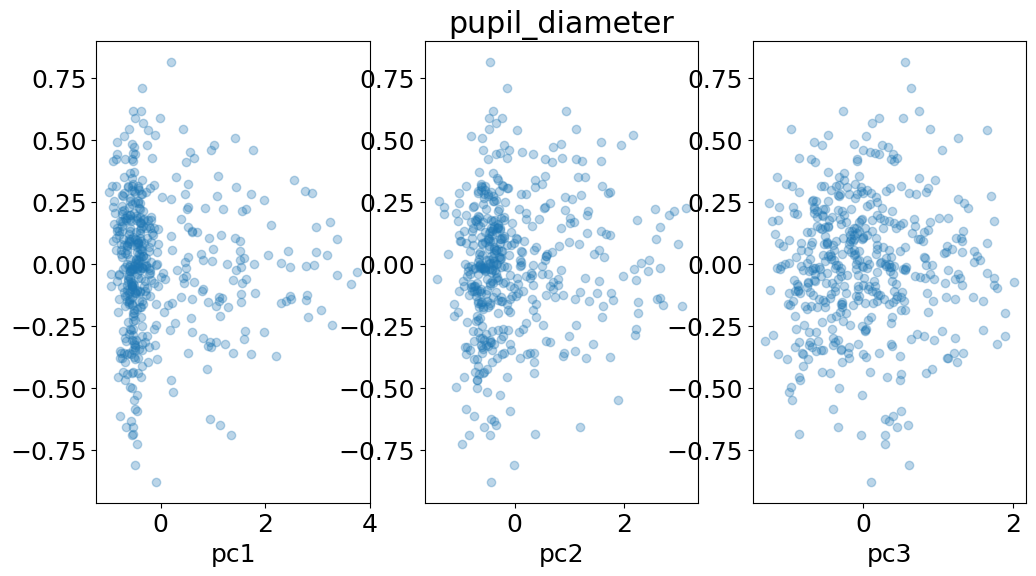

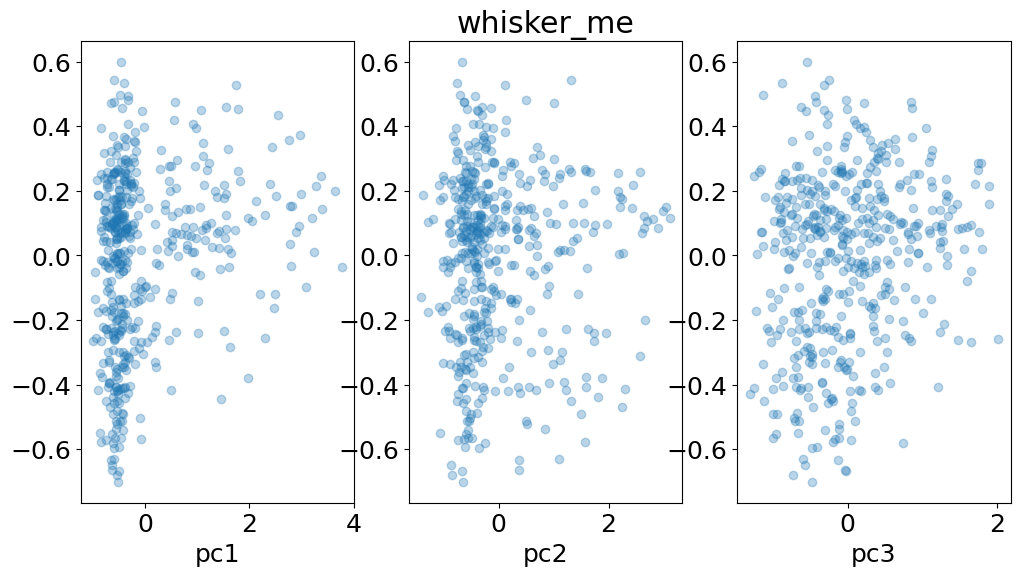

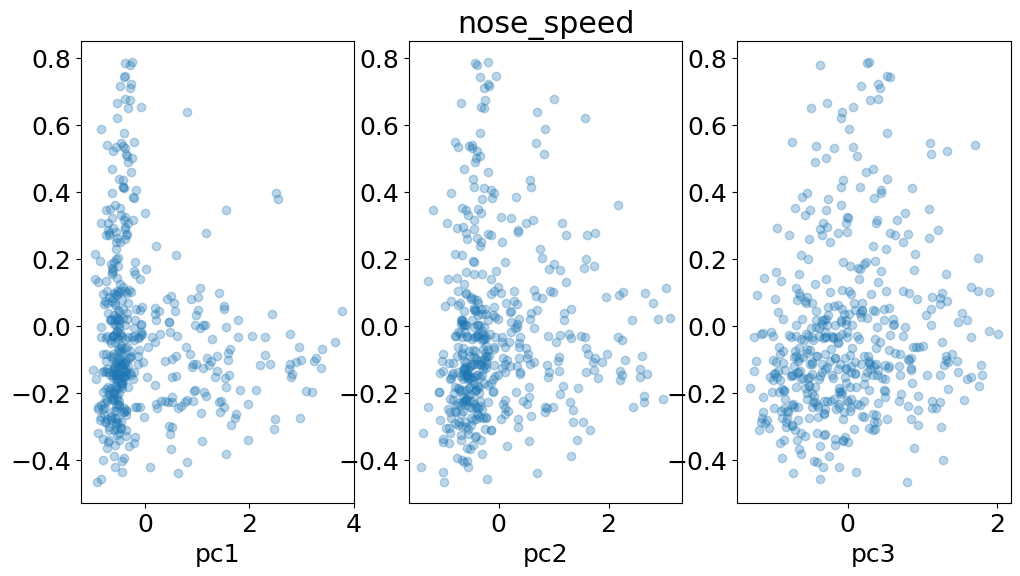

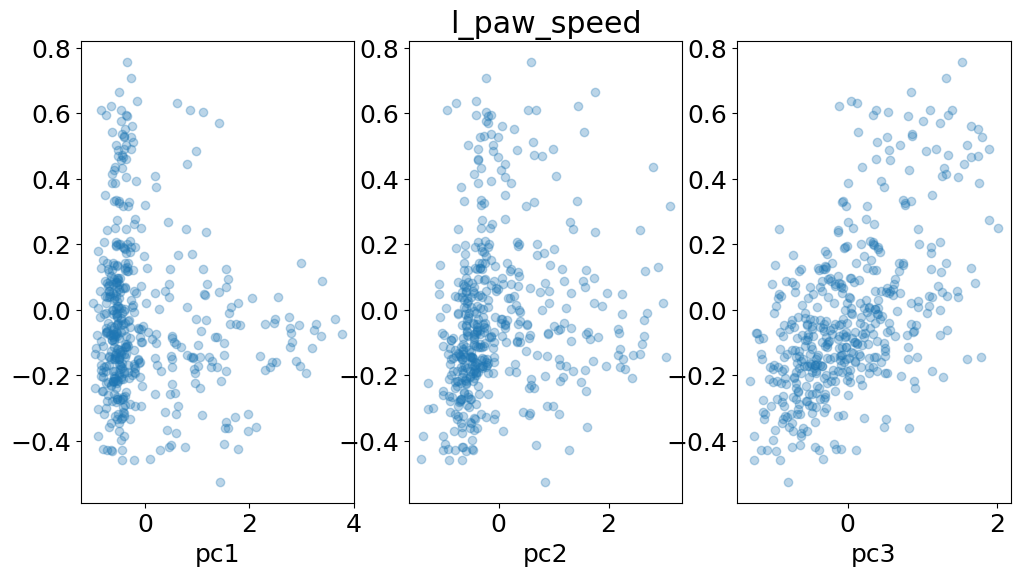

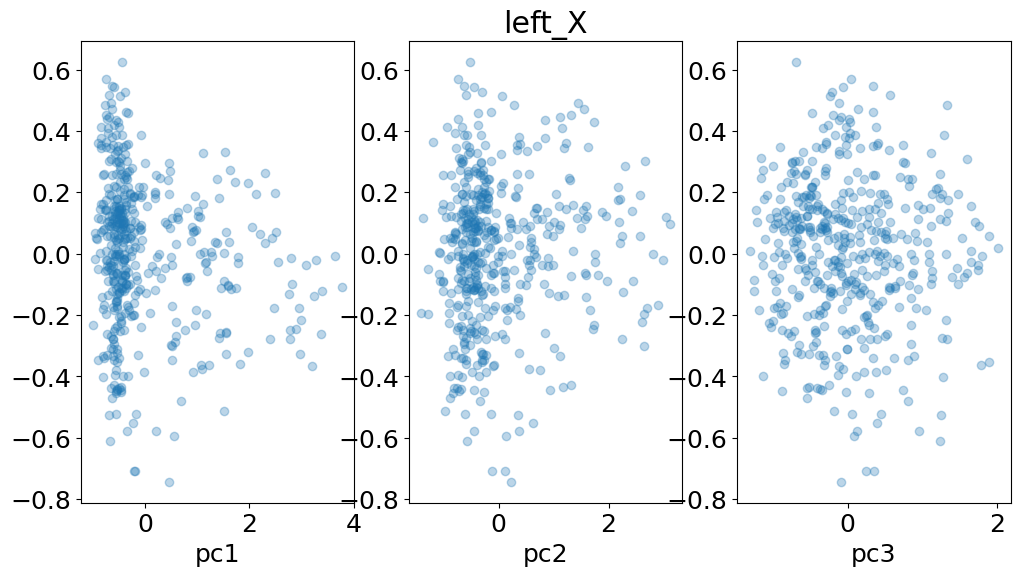

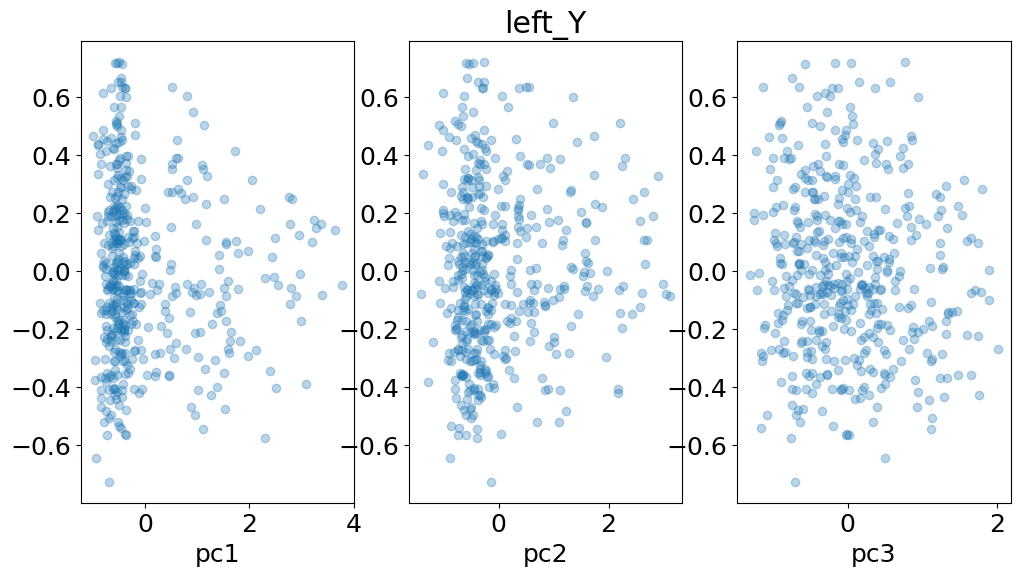

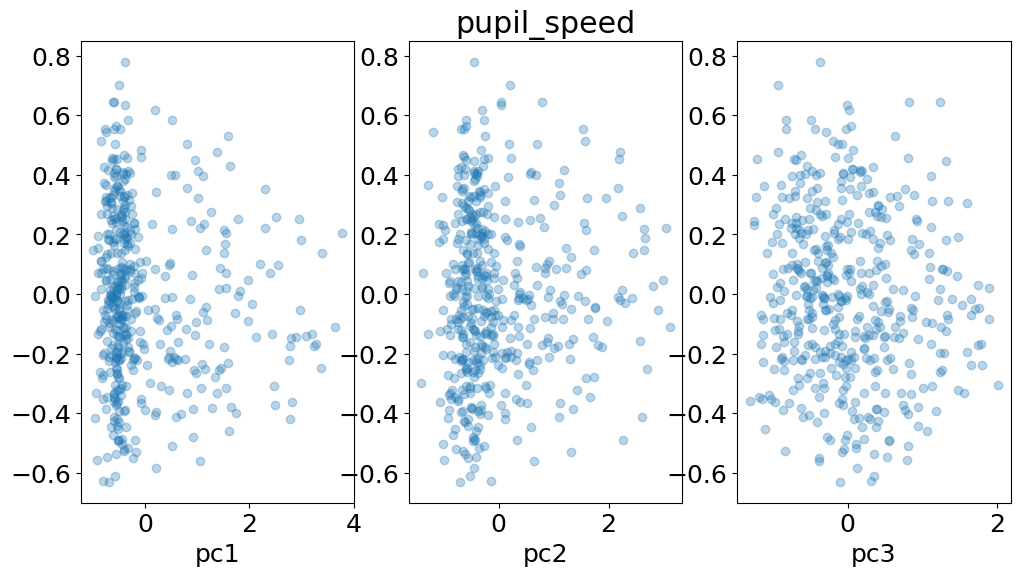

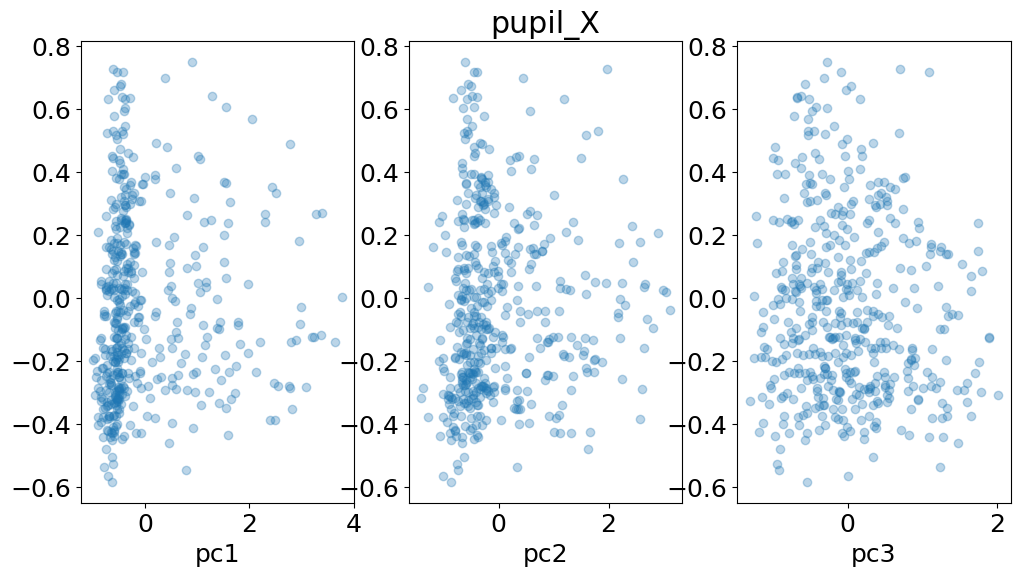

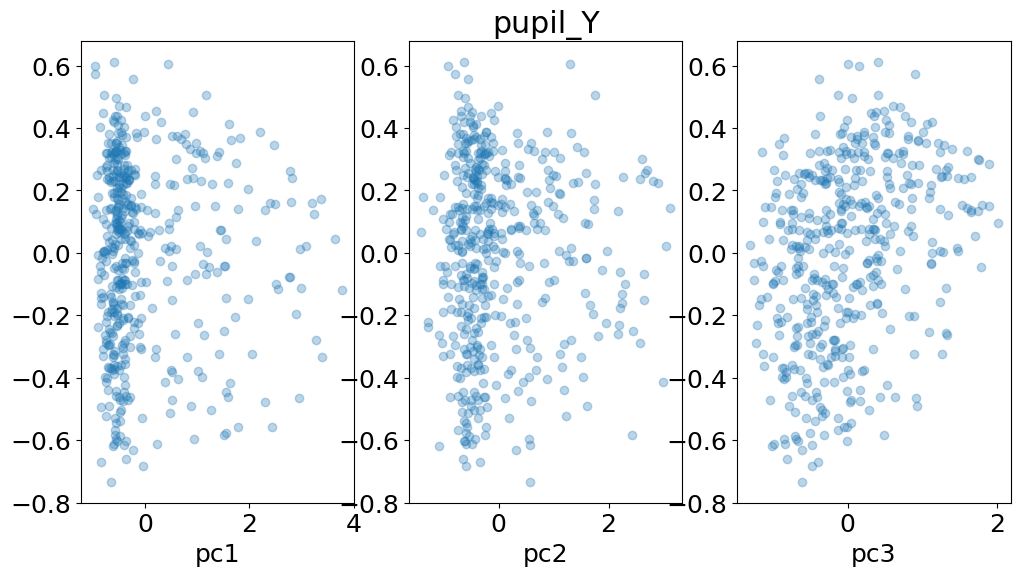

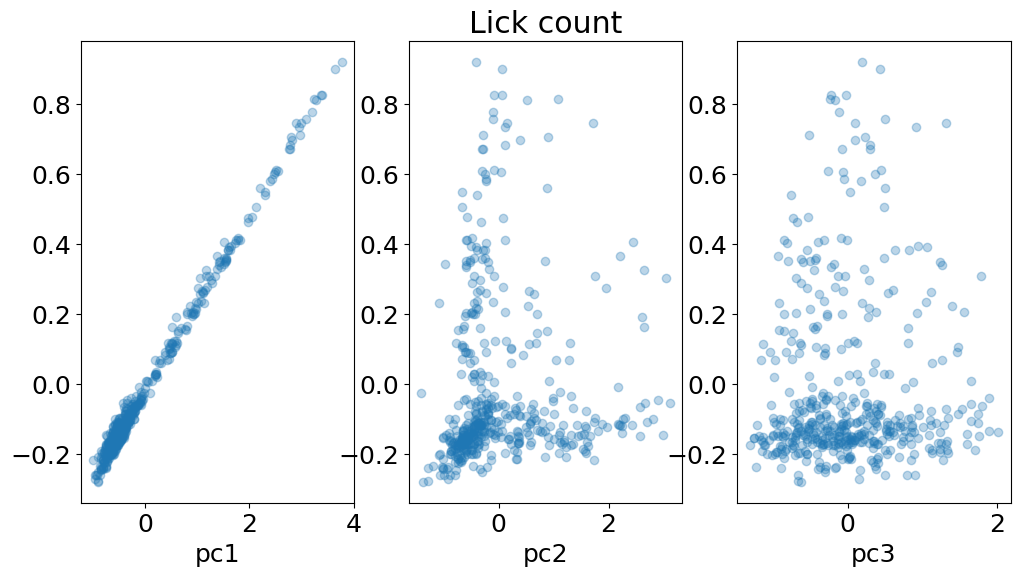

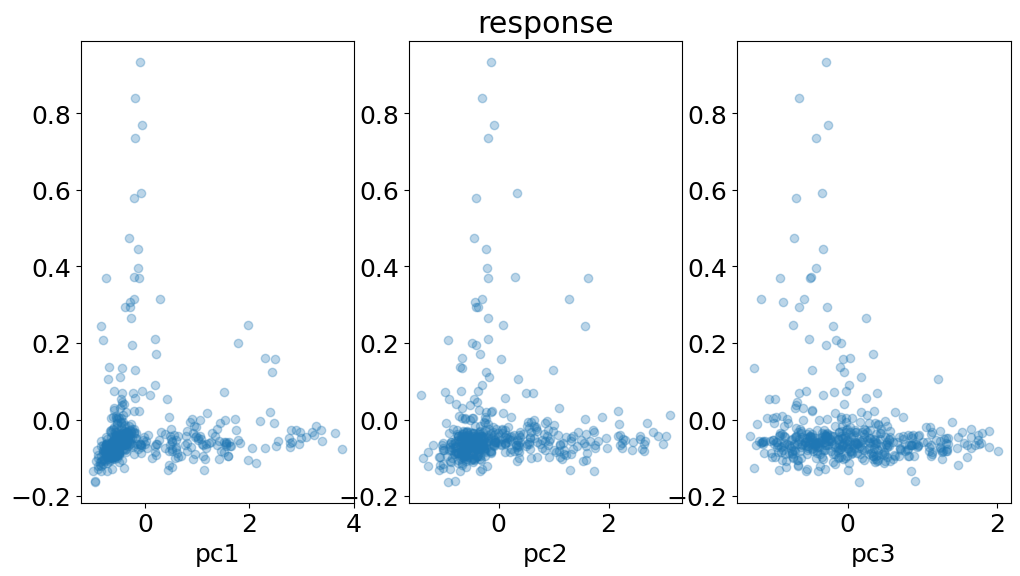

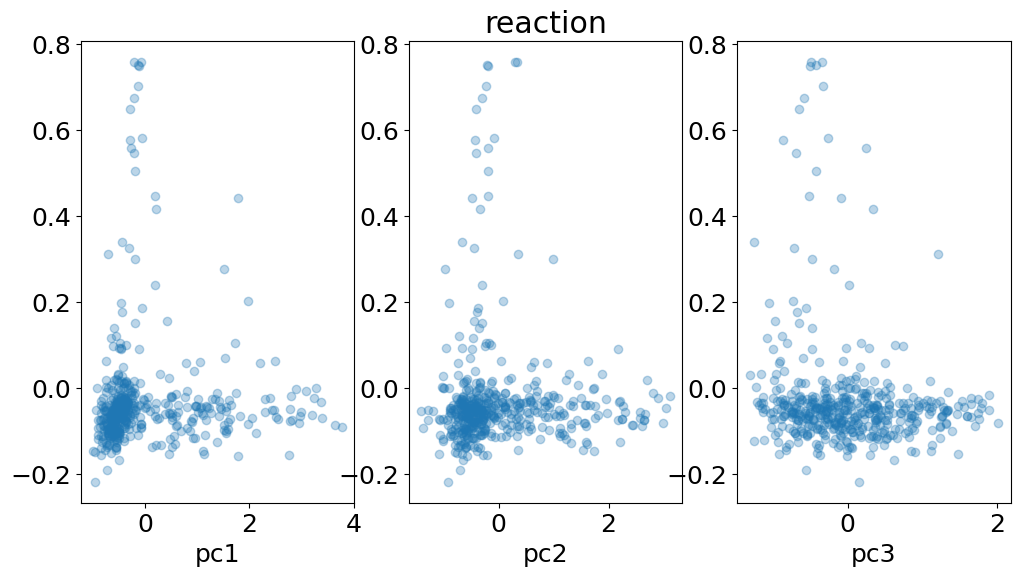

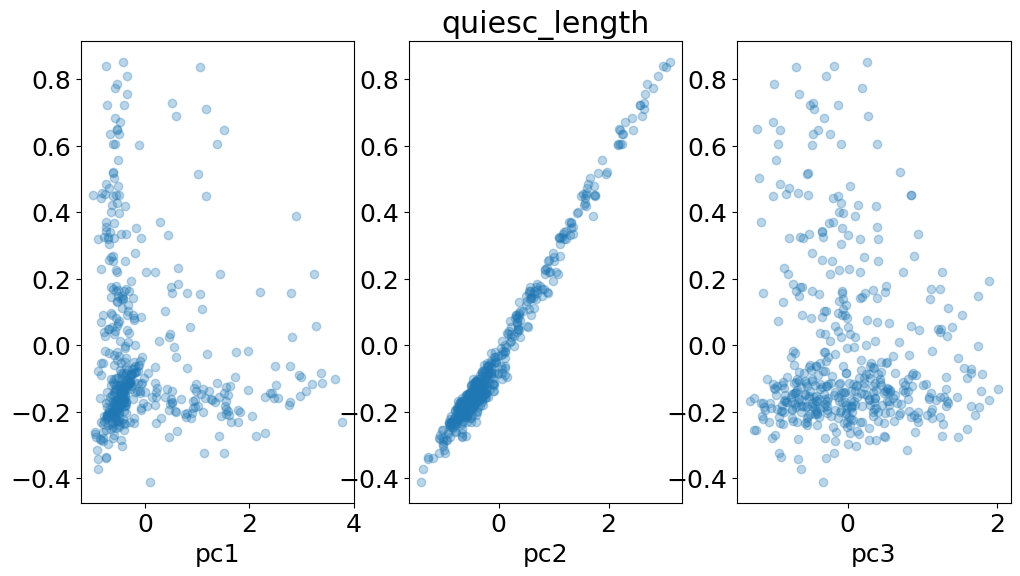

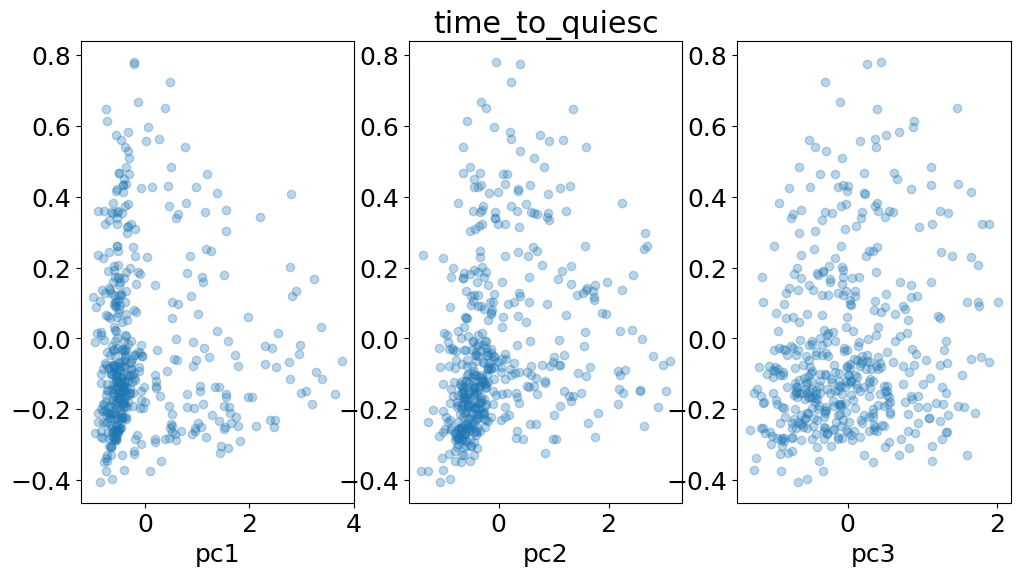

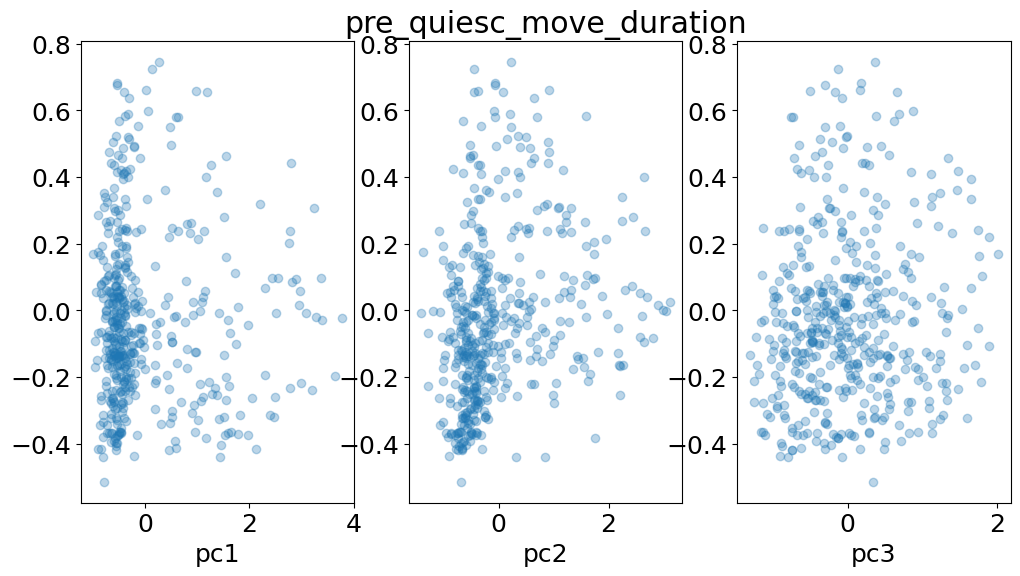

In [51]:
variable_names = use_data.keys()
for v, var in enumerate(variable_names):
    fig, ax = plt.subplots(ncols=3, nrows=1, sharex=False, sharey=False, figsize=[12, 6])
    ax[0].scatter(np.array(augmented_data['pc1']), X[:, v], alpha=0.3)
    ax[1].scatter(np.array(augmented_data['pc2']), X[:, v], alpha=0.3)
    ax[2].scatter(np.array(augmented_data['pc3']), X[:, v], alpha=0.3)
    
    ax[0].set_xlabel('pc1')
    ax[1].set_xlabel('pc2')
    ax[2].set_xlabel('pc3')
    
    ax[1].set_title(var)
    plt.show()

## Overlay trial trajectories

## K-means clustering

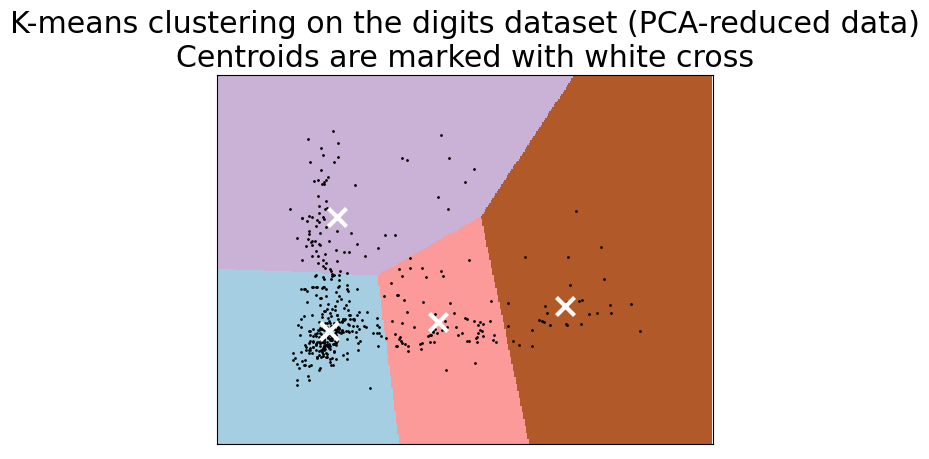

In [52]:
cluster_num = 4

kmeans = KMeans(init="k-means++", n_clusters=cluster_num, n_init=4)
kmeans.fit(X_reduced[:, 0:2])

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(X_reduced[:, 0], X_reduced[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()